In [53]:
import string
import numpy as np
from collections import Counter
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [54]:
data=pd.read_csv("restaurant_names.csv")
data.head()



,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [55]:
data1=pd.read_csv("restaurant_reviews.csv")
data1.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.1+ KB


In [57]:
data1 = data1[data1["Rating"] != "Like"]
data1["Rating"].value_counts()

Rating
5      3832
4      2373
1      1735
3      1193
2       684
4.5      69
3.5      47
2.5      19
1.5       9
Name: count, dtype: int64

In [58]:
data1["Rating"] = data1["Rating"].astype("float")

In [59]:
data1.describe()

,Rating,Pictures
count,9961.000000,9999.000000
mean,3.601044,0.748575
std,1.483461,2.570508
min,1.000000,0.000000
25%,3.000000,0.000000
50%,4.000000,0.000000
75%,5.000000,0.000000
max,5.000000,64.000000


In [60]:
#Droping rows which have null
data1.dropna(how='any',inplace=True)
data1.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9954 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  9954 non-null   object 
 1   Reviewer    9954 non-null   object 
 2   Review      9954 non-null   object 
 3   Rating      9954 non-null   float64
 4   Metadata    9954 non-null   object 
 5   Time        9954 non-null   object 
 6   Pictures    9954 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 622.1+ KB


In [61]:
#Convert metadat to str
data1["Metadata"] = data1["Metadata"].astype("str")

In [62]:

data1[['No_of_Reviews','No_of_Followers']] = data1["Metadata"].str.split("," , expand=True)

# Delete Metadata Column
del data1["Metadata"]
data1[:3]

,Restaurant,Reviewer,Review,Rating,Time,Pictures,No_of_Reviews,No_of_Followers
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,5/25/2019 15:54,0,1 Review,2 Followers
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,5/25/2019 14:20,0,3 Reviews,2 Followers
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,5/24/2019 22:54,0,2 Reviews,3 Followers


In [63]:
data1['No_of_Reviews'] = pd.to_numeric(data1['No_of_Reviews'].astype(str).str.replace(r'\D+', '', regex=True)).fillna(0).astype(int)
data1['No_of_Followers'] = pd.to_numeric(data1['No_of_Followers'].astype(str).str.replace(r'\D+', '', regex=True)).fillna(0).astype(int)


In [64]:
print(data1)

            Restaurant              Reviewer  \
0      Beyond Flavours     Rusha Chakraborty   
1      Beyond Flavours  Anusha Tirumalaneedi   
2      Beyond Flavours       Ashok Shekhawat   
3      Beyond Flavours        Swapnil Sarkar   
4      Beyond Flavours                Dileep   
...                ...                   ...   
9995  Chinese Pavilion      Abhishek Mahajan   
9996  Chinese Pavilion        Sharad Agrawal   
9997  Chinese Pavilion             Ramandeep   
9998  Chinese Pavilion       Nayana Shanbhag   
9999  Chinese Pavilion      Bhargava Krishna   

                                                 Review  Rating  \
0     The ambience was good, food was quite good . h...     5.0   
1     Ambience is too good for a pleasant evening. S...     5.0   
2     A must try.. great food great ambience. Thnx f...     5.0   
3     Soumen das and Arun was a great guy. Only beca...     5.0   
4     Food is good.we ordered Kodi drumsticks and ba...     5.0   
...                  

In [65]:
data1["No_of_Followers"] = data1["No_of_Followers"].replace(np.nan, 0)
data1["No_of_Followers"] = data1["No_of_Followers"].astype("int")

In [66]:
trr = data1.groupby("Restaurant")["Rating"].agg("mean").to_frame().reset_index().sort_values(by = "Rating", ascending = False)
trr_10 = trr[:10]
trr_10

,Restaurant,Rating
3,AB's - Absolute Barbecues,4.88
11,B-Dubs,4.81
2,"3B's - Buddies, Bar & Barbecue",4.76
67,Paradise,4.70
35,Flechazo,4.66
87,The Indi Grill,4.60
97,Zega - Sheraton Hyderabad Hotel,4.45
64,Over The Moon Brew Company,4.34
16,Beyond Flavours,4.28
19,Cascade - Radisson Hyderabad Hitec City,4.26


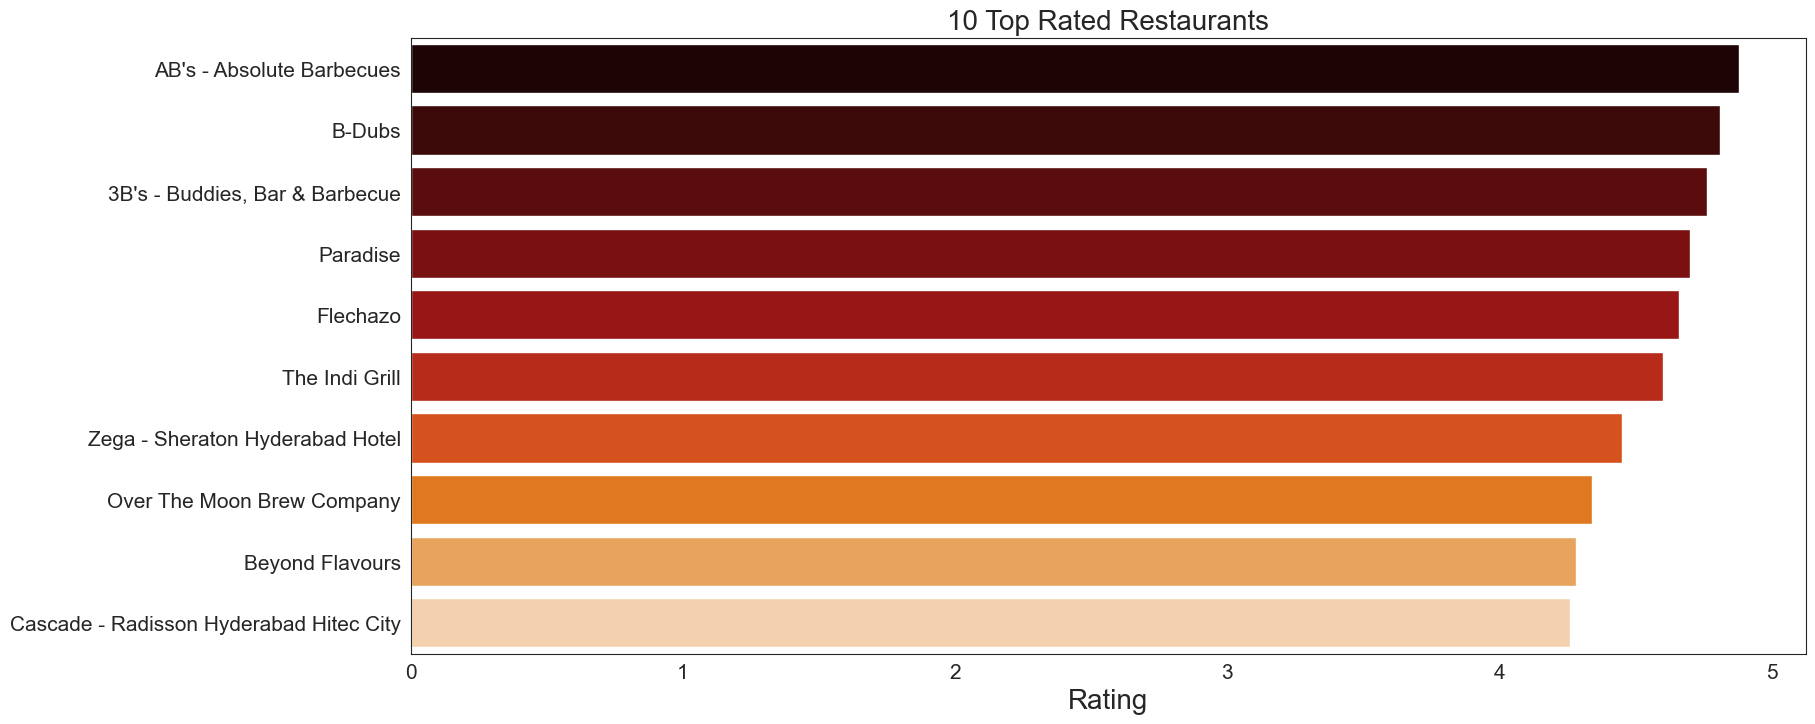

In [67]:
sns.set_style("white")
plt.figure(figsize = (18, 8))
sns.barplot(x = "Rating", y = "Restaurant", data = trr_10, palette = "gist_heat")
plt.title("10 Top Rated Restaurants", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Rating", size = 20)
plt.ylabel(None)
plt.savefig("10_Top_Rated_Restaurants.png")
plt.show()

In [68]:
trer = data1.groupby("Restaurant")["No_of_Reviews"].agg("sum").reset_index().sort_values(by = "No_of_Reviews", ascending = False)
trer_10 = trer[:10]
trer_10


,Restaurant,No_of_Reviews
55,Labonel,6628
68,Pista House,5429
20,Chinese Pavilion,5409
31,Dunkin' Donuts,5289
89,The Old Madras Baking Company,5115
22,Collage - Hyatt Hyderabad Gachibowli,4764
19,Cascade - Radisson Hyderabad Hitec City,4444
44,Hyderabadi Daawat,4412
33,Faasos,4392
30,Driven Cafe,4378


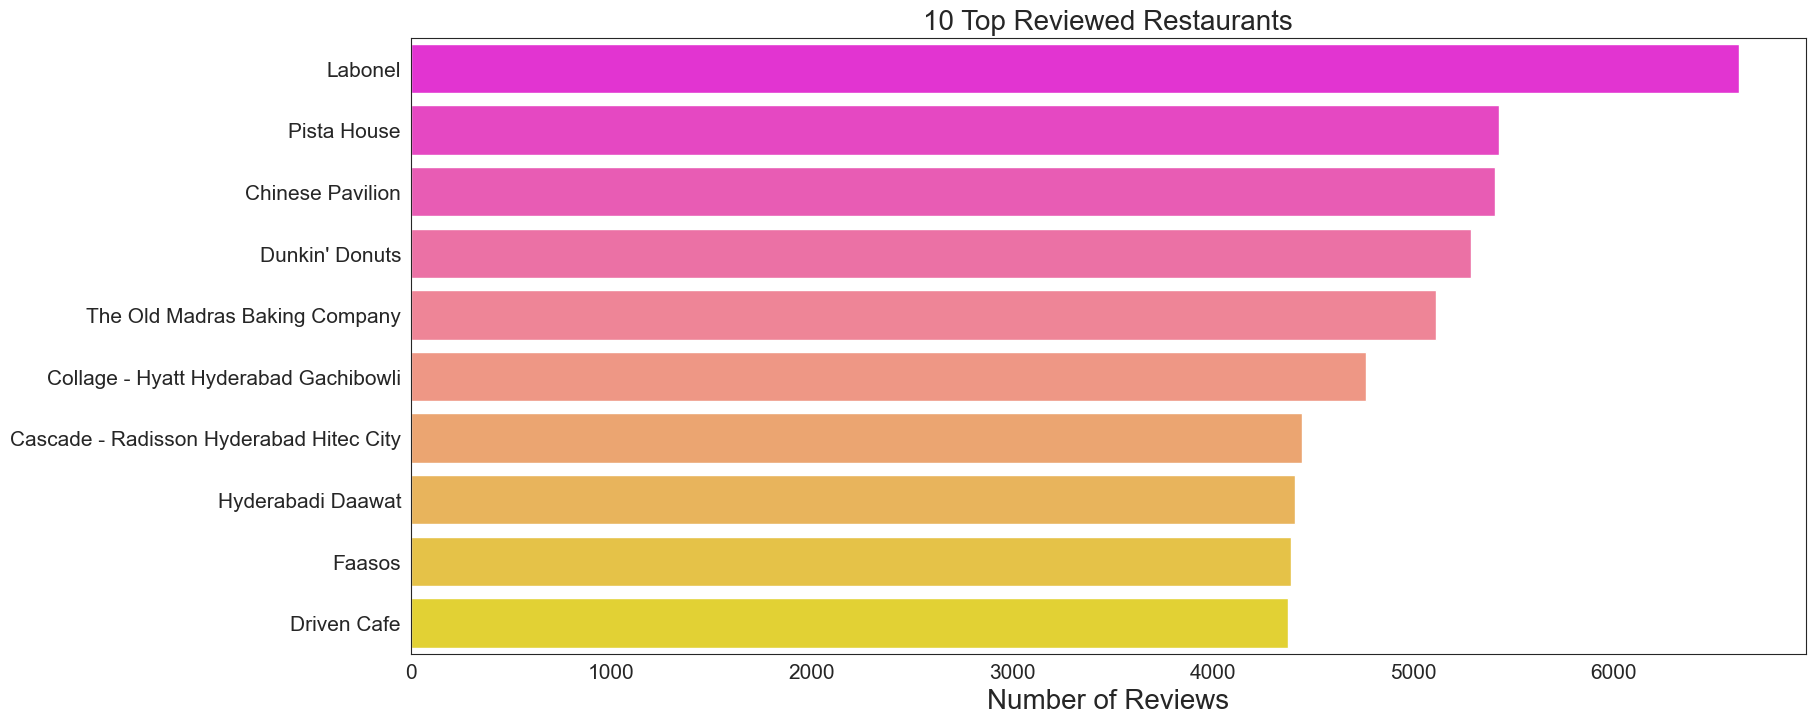

In [69]:
plt.figure(figsize = (18, 8))
sns.barplot(x = "No_of_Reviews", y = "Restaurant", data = trer_10, palette = "spring")
plt.title("10 Top Reviewed Restaurants", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Number of Reviews", size = 20)
plt.ylabel(None)
plt.savefig("10_Top_Reviewed_Restaurants.png")
plt.show()

In [70]:
tfr = data1.groupby("Restaurant")["No_of_Followers"].agg("sum").reset_index().sort_values(by = "No_of_Followers", ascending = False)
tfr_10 = tfr[:10]
tfr_10

,Restaurant,No_of_Followers
68,Pista House,51068
52,Komatose - Holiday Inn Express & Suites,46229
44,Hyderabadi Daawat,45375
90,The Tilt Bar Republic,42126
31,Dunkin' Donuts,37667
20,Chinese Pavilion,35426
33,Faasos,34640
80,T Grill,32222
19,Cascade - Radisson Hyderabad Hitec City,31644
13,Barbeque Nation,30866


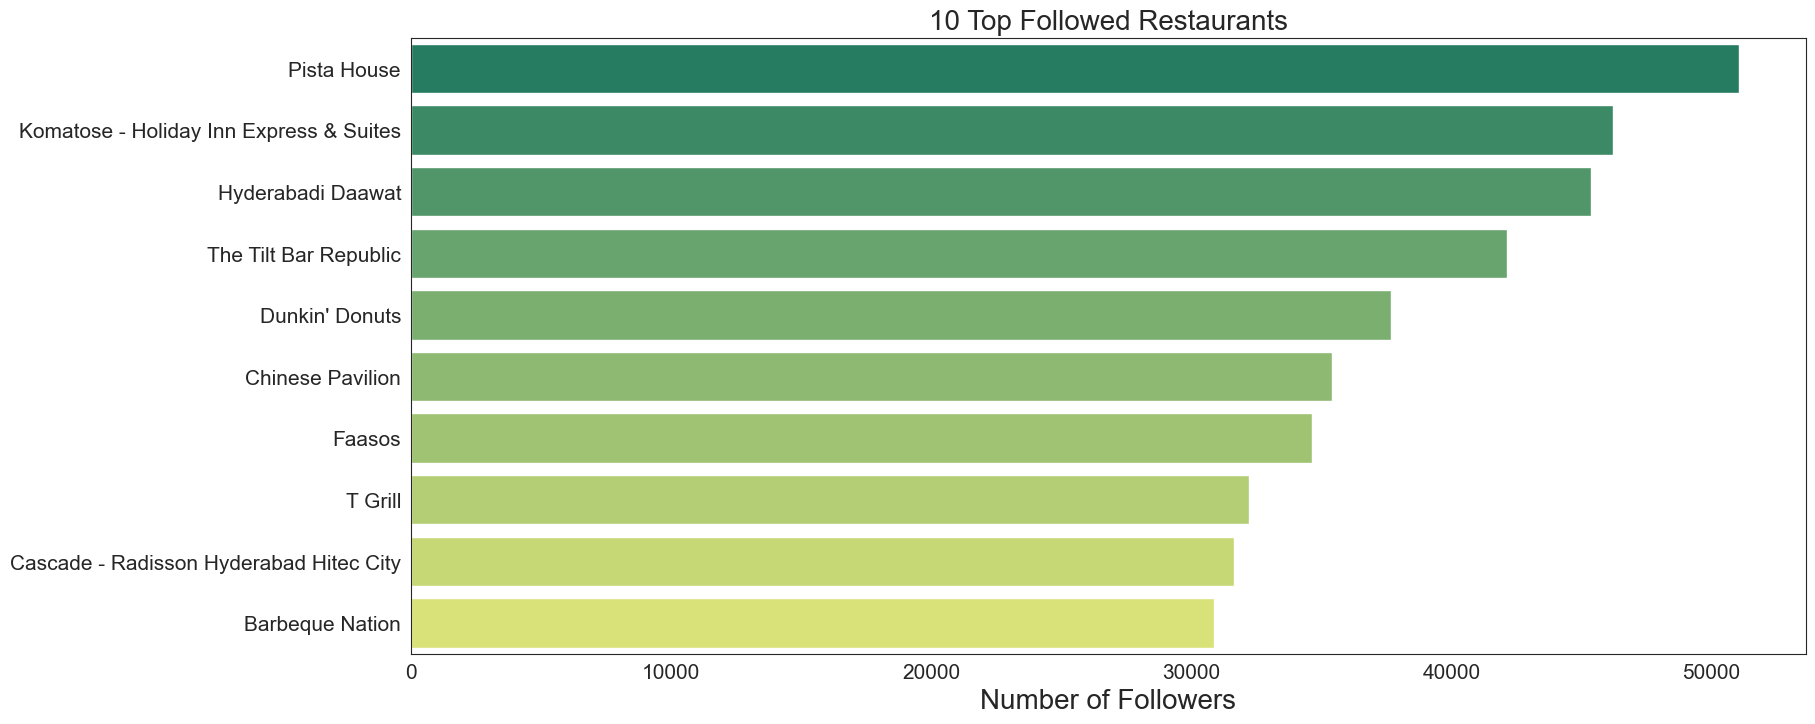

In [71]:
plt.figure(figsize = (18, 8))
sns.barplot(x = "No_of_Followers", y = "Restaurant", data = tfr_10, palette = "summer")
plt.title("10 Top Followed Restaurants", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Number of Followers", size = 20)
plt.ylabel(None)
plt.savefig("10_Top_Followed_Restaurants.png")
plt.show()

In [72]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [73]:
STOPWORDS = set(stopwordlist)

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data1['Review'] = data1['Review'].apply(lambda text: cleaning_stopwords(text))
data1['Review'].head()

0    The ambience good, food quite good . Saturday ...
1    Ambience good pleasant evening. Service prompt...
2    A must try.. great food great ambience. Thnx s...
3    Soumen das Arun great guy. Only behavior since...
4    Food good.we ordered Kodi drumsticks basket mu...
Name: Review, dtype: object

In [74]:
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

data1['Review'] = data1['Review'].apply(lambda x: cleaning_punctuations(x))
data1['Review'].tail()

9995    Madhumathi Mahajan Well start nice courteous s...
9996    This place never disappointed us The food cour...
9997    Bad rating mainly Chicken Bone found Veg food ...
9998    I personally love prefer Chinese Food Had coup...
9999    Checked try delicious chinese food here seen n...
Name: Review, dtype: object

In [75]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

data1['Review'] = data1['Review'].apply(lambda x: cleaning_repeating_char(x))
data1['Review'].tail()

9995    Madhumathi Mahajan Well start nice courteous s...
9996    This place never disappointed us The food cour...
9997    Bad rating mainly Chicken Bone found Veg food ...
9998    I personally love prefer Chinese Food Had coup...
9999    Checked try delicious chinese food here seen n...
Name: Review, dtype: object

In [76]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

data1['Review'] = data1['Review'].apply(lambda x: cleaning_numbers(x))
data1['Review'].tail()

9995    Madhumathi Mahajan Well start nice courteous s...
9996    This place never disappointed us The food cour...
9997    Bad rating mainly Chicken Bone found Veg food ...
9998    I personally love prefer Chinese Food Had coup...
9999    Checked try delicious chinese food here seen n...
Name: Review, dtype: object

In [77]:
text = ' '.join(data1["Review"])
words = text.split()

two_words = {' '.join(words):n for words,n in Counter(zip(words, words[1:])).items() if not  words[0][-1]==(',')}

In [78]:
two_words_df = pd.DataFrame(two_words.items(), columns=['Reviews Words', 'Frequency'])
two_words_df = two_words_df.sort_values(by = "Frequency", ascending = False)
two_words_20 = two_words_df[:20]
two_words_20

,Reviews Words,Frequency
2874,I ordered,559
554,The food,471
294,We ordered,391
1433,main course,387
207,really good,376
72,I would,371
1063,This place,353
2069,not good,349
459,good but,318
75,visit place,315


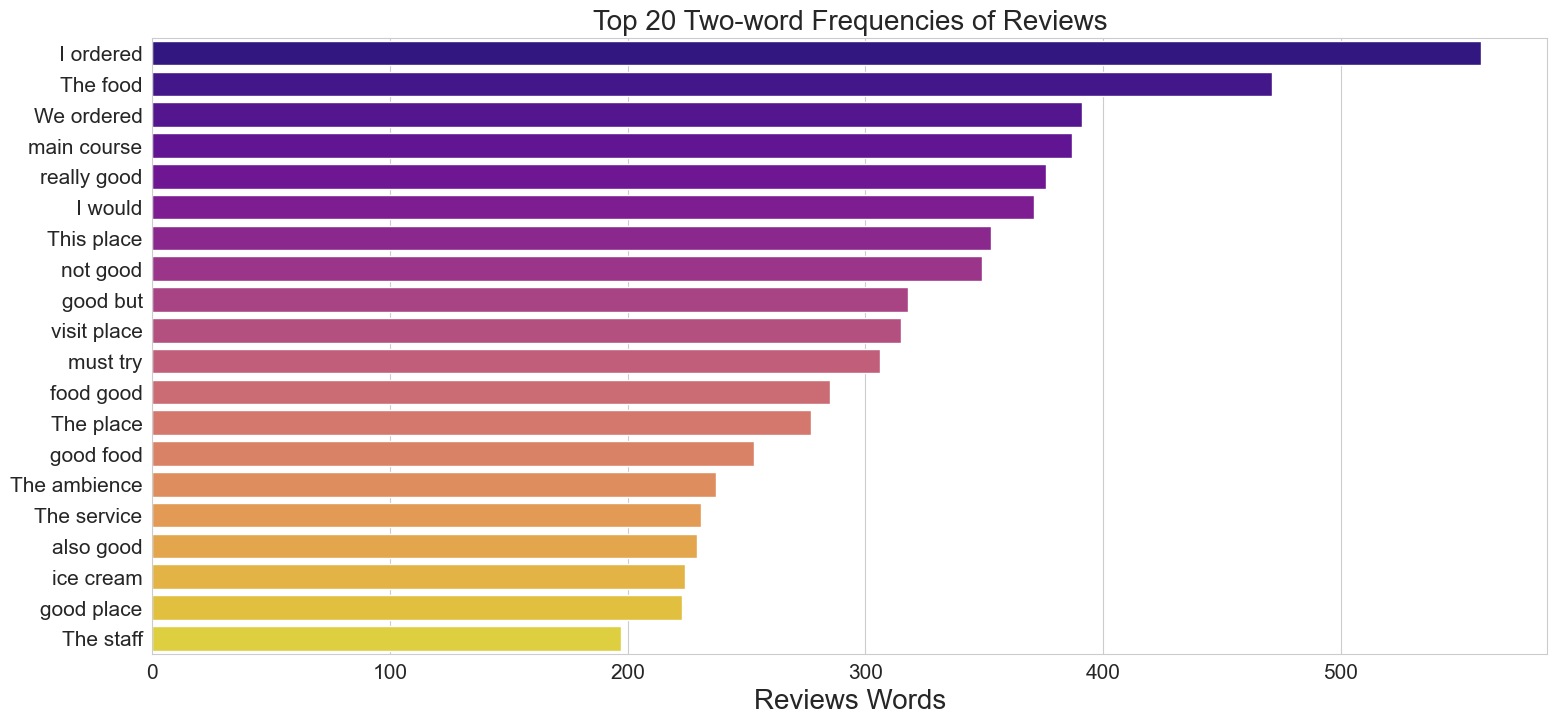

In [79]:
sns.set_style("whitegrid")
plt.figure(figsize = (18, 8))
sns.barplot(y = "Reviews Words", x = "Frequency", data = two_words_20, palette = "plasma")
plt.title("Top 20 Two-word Frequencies of Reviews", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Reviews Words", size = 20)
plt.ylabel(None)
plt.savefig("Top_20_Two-word_Frequencies_of_Reviews.png")
plt.show()

In [80]:
data['Cuisines'] = data['Cuisines'].apply(lambda text: cleaning_stopwords(text))
data['Cuisines'].head()

0    Chinese, Continental, Kebab, European, South I...
1                       Biryani, North Indian, Chinese
2         Asian, Mediterranean, North Indian, Desserts
3    Biryani, North Indian, Chinese, Seafood, Bever...
4    Asian, Continental, North Indian, Chinese, Med...
Name: Cuisines, dtype: object

In [81]:
data['Cuisines'] = data['Cuisines'].apply(lambda x: cleaning_punctuations(x))
data['Cuisines'].head()

0    Chinese Continental Kebab European South India...
1                         Biryani North Indian Chinese
2            Asian Mediterranean North Indian Desserts
3       Biryani North Indian Chinese Seafood Beverages
4    Asian Continental North Indian Chinese Mediter...
Name: Cuisines, dtype: object

In [82]:
data['Cuisines'] = data['Cuisines'].apply(lambda x: cleaning_repeating_char(x))
data['Cuisines'].head()

0    Chinese Continental Kebab European South India...
1                         Biryani North Indian Chinese
2            Asian Mediterranean North Indian Desserts
3       Biryani North Indian Chinese Seafood Beverages
4    Asian Continental North Indian Chinese Mediter...
Name: Cuisines, dtype: object

In [83]:
data['Cuisines'] = data['Cuisines'].apply(lambda x: cleaning_numbers(x))
data['Cuisines'].head()

0    Chinese Continental Kebab European South India...
1                         Biryani North Indian Chinese
2            Asian Mediterranean North Indian Desserts
3       Biryani North Indian Chinese Seafood Beverages
4    Asian Continental North Indian Chinese Mediter...
Name: Cuisines, dtype: object

In [84]:
text = ' '.join(data['Cuisines'])
words = text.split()

two_words = {' '.join(words):n for words,n in Counter(zip(words, words[1:])).items() if not  words[0][-1]==(',')}

In [85]:
two_words_dfc = pd.DataFrame(two_words.items(), columns=['Cuisine Words', 'Frequency'])
two_words_dfc = two_words_dfc.sort_values(by = "Frequency", ascending = False)
two_words_20c = two_words_dfc[:20]
two_words_20c

,Cuisine Words,Frequency
6,North Indian,61
9,Indian Chinese,27
42,Fast Food,15
4,South Indian,9
5,Indian North,9
33,Chinese North,8
24,Indian Continental,6
65,Italian North,6
8,Biryani North,6
28,Food North,6


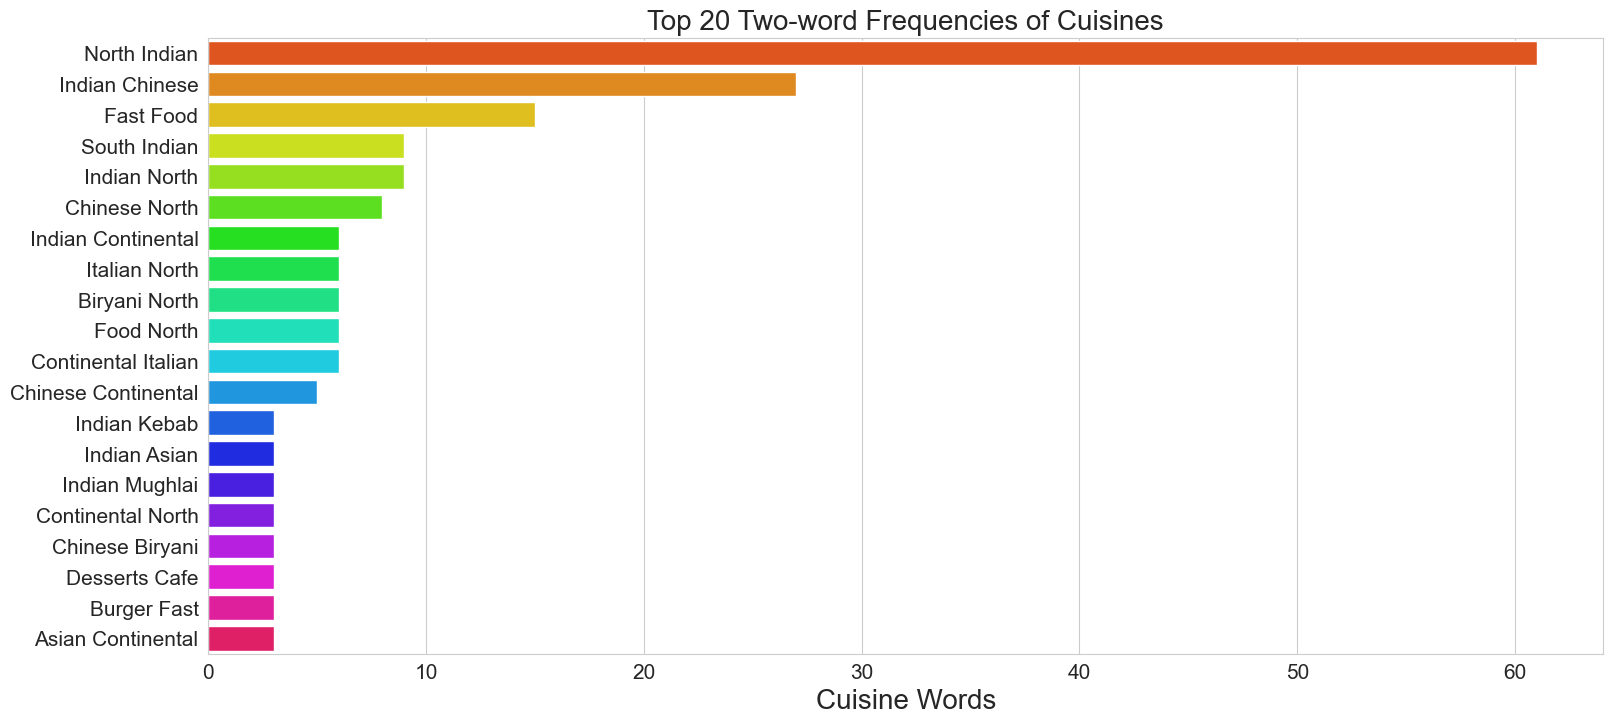

In [86]:
sns.set_style("whitegrid")
plt.figure(figsize = (18, 8))
sns.barplot(y = "Cuisine Words", x = "Frequency", data = two_words_20c, palette = "hsv")
plt.title("Top 20 Two-word Frequencies of Cuisines", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Cuisine Words", size = 20)
plt.ylabel(None)
plt.savefig("Top_20_Two-word_Frequencies_of_Cuisines.png")
plt.show()

In [87]:
df1 = pd.read_csv("restaurant_reviews.csv")

In [88]:
df2 = pd.read_csv("restaurant_names.csv")

In [89]:
df2[:3]

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"


In [90]:
df2["Cuisines"] = df2["Cuisines"].str.split(",")
df2[:3]

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","[Chinese, Continental, Kebab, European, So...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"[Biryani, North Indian, Chinese]",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","[Asian, Mediterranean, North Indian, Desserts]","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"


In [91]:
df_c = df2.copy()

# iterate in cuisine column
for index, row in df2.iterrows():
    for genre in row["Cuisines"]:
        df_c.at[index, genre] = 1

#Filling in the NaN values with 0 to show that a movie doesn't have that column's
df_c = df_c.fillna(0)
df_c.head().T

,0,1,2,3,4
Name,Beyond Flavours,Paradise,Flechazo,Shah Ghouse Hotel & Restaurant,Over The Moon Brew Company
Links,https://www.zomato.com/hyderabad/beyond-flavou...,https://www.zomato.com/hyderabad/paradise-gach...,https://www.zomato.com/hyderabad/flechazo-gach...,https://www.zomato.com/hyderabad/shah-ghouse-h...,https://www.zomato.com/hyderabad/over-the-moon...
Cost,800,800,"1,300",800,"1,200"
Collections,"Food Hygiene Rated Restaurants in Hyderabad, C...",Hyderabad's Hottest,"Great Buffets, Hyderabad's Hottest",Late Night Restaurants,"Best Bars & Pubs, Food Hygiene Rated Restauran..."
Cuisines,"[Chinese, Continental, Kebab, European, So...","[Biryani, North Indian, Chinese]","[Asian, Mediterranean, North Indian, Desserts]","[Biryani, North Indian, Chinese, Seafood, ...","[Asian, Continental, North Indian, Chinese,..."
...,...,...,...,...,...
Cafe,0.0,0.0,0.0,0.0,0.0
Hyderabadi,0.0,0.0,0.0,0.0,0.0
Mithai,0.0,0.0,0.0,0.0,0.0
Thai,0.0,0.0,0.0,0.0,0.0


In [92]:
userInput = [
            {'Restaurant':"Pakwaan Grand", 'Rating':5},
            {'Restaurant':"Club Rogue", 'Rating':3.5},
            {'Restaurant':"Flechazo", 'Rating':2},
            {'Restaurant':"Green Bawarchi Restaurant", 'Rating':5},
            {'Restaurant':"Dunkin' Donuts", 'Rating':4.5}
         ]
inputRestaurant = pd.DataFrame(userInput)
inputRestaurant

,Restaurant,Rating
0,Pakwaan Grand,5.0
1,Club Rogue,3.5
2,Flechazo,2.0
3,Green Bawarchi Restaurant,5.0
4,Dunkin' Donuts,4.5


In [93]:

input_res = df2[df2["Name"].isin(inputRestaurant["Restaurant"].to_list())]
input_res = input_res.rename(columns = {"Name": "Restaurant"})
input_res

,Restaurant,Links,Cost,Collections,Cuisines,Timings
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","[Asian, Mediterranean, North Indian, Desserts]","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
19,Pakwaan Grand,https://www.zomato.com/hyderabad/pakwaan-grand...,400,Trending This Week,"[North Indian, Chinese, Biryani]",12 Noon to 11 PM
33,Club Rogue,https://www.zomato.com/hyderabad/club-rogue-ga...,900,NaN,"[North Indian, Fast Food]",11 AM to 12 Midnight
35,Green Bawarchi Restaurant,https://www.zomato.com/hyderabad/green-bawarch...,700,NaN,"[North Indian, Chinese, Biryani]",12 Noon to 11 PM
94,Dunkin' Donuts,https://www.zomato.com/hyderabad/dunkin-donuts...,550,NaN,"[Desserts, Cafe, Beverages, Burger, Fast F...",10 AM to 11 PM


In [94]:

inputRestaurant = inputRestaurant.set_index("Restaurant")

In [95]:
input_res = input_res.set_index("Restaurant")

In [96]:
inputRestaurant = pd.merge(inputRestaurant, input_res, left_index = True, right_index = True)
inputRestaurant

,Rating,Links,Cost,Collections,Cuisines,Timings
Restaurant,,,,,,
Pakwaan Grand,5.0,https://www.zomato.com/hyderabad/pakwaan-grand...,400,Trending This Week,"[North Indian, Chinese, Biryani]",12 Noon to 11 PM
Club Rogue,3.5,https://www.zomato.com/hyderabad/club-rogue-ga...,900,NaN,"[North Indian, Fast Food]",11 AM to 12 Midnight
Flechazo,2.0,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","[Asian, Mediterranean, North Indian, Desserts]","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
Green Bawarchi Restaurant,5.0,https://www.zomato.com/hyderabad/green-bawarch...,700,NaN,"[North Indian, Chinese, Biryani]",12 Noon to 11 PM
Dunkin' Donuts,4.5,https://www.zomato.com/hyderabad/dunkin-donuts...,550,NaN,"[Desserts, Cafe, Beverages, Burger, Fast F...",10 AM to 11 PM


In [97]:
inputRestaurant = inputRestaurant.reset_index()
inputRestaurant = inputRestaurant[["Restaurant", "Cuisines", "Rating"]]
inputRestaurant

,Restaurant,Cuisines,Rating
0,Pakwaan Grand,"[North Indian, Chinese, Biryani]",5.0
1,Club Rogue,"[North Indian, Fast Food]",3.5
2,Flechazo,"[Asian, Mediterranean, North Indian, Desserts]",2.0
3,Green Bawarchi Restaurant,"[North Indian, Chinese, Biryani]",5.0
4,Dunkin' Donuts,"[Desserts, Cafe, Beverages, Burger, Fast F...",4.5


In [98]:
user_Restaurants = df_c[df_c["Name"].isin(inputRestaurant["Restaurant"].to_list())]
user_Restaurants

,Name,Links,Cost,Collections,Cuisines,Timings,Chinese,Continental,Kebab,European,...,Burger,Momos,Pizza,Arabian,North Eastern,Cafe,Hyderabadi,Mithai,Thai,Malaysian
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","[Asian, Mediterranean, North Indian, Desserts]","11:30 AM to 4:30 PM, 6:30 PM to 11 PM",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,Pakwaan Grand,https://www.zomato.com/hyderabad/pakwaan-grand...,400,Trending This Week,"[North Indian, Chinese, Biryani]",12 Noon to 11 PM,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,Club Rogue,https://www.zomato.com/hyderabad/club-rogue-ga...,900,0,"[North Indian, Fast Food]",11 AM to 12 Midnight,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,Green Bawarchi Restaurant,https://www.zomato.com/hyderabad/green-bawarch...,700,0,"[North Indian, Chinese, Biryani]",12 Noon to 11 PM,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,Dunkin' Donuts,https://www.zomato.com/hyderabad/dunkin-donuts...,550,0,"[Desserts, Cafe, Beverages, Burger, Fast F...",10 AM to 11 PM,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [99]:
user_Restaurants = user_Restaurants.reset_index(drop = True)
user_Restaurants  = user_Restaurants.drop(columns = ["Name", "Links", "Cost", "Collections", "Cuisines", "Timings"])
user_Restaurants

,Chinese,Continental,Kebab,European,South Indian,North Indian,Biryani,Chinese,Asian,Mediterranean,...,Burger,Momos,Pizza,Arabian,North Eastern,Cafe,Hyderabadi,Mithai,Thai,Malaysian
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [100]:
userProfile = user_Restaurants.transpose().dot(inputRestaurant["Rating"])
userProfile

Chinese          0.0
 Continental     0.0
 Kebab           0.0
 European        0.0
 South Indian    0.0
                ... 
 Cafe            4.5
Hyderabadi       0.0
 Mithai          0.0
Thai             0.0
 Malaysian       0.0
Length: 70, dtype: float64

In [101]:
CuisineTable = df_c.set_index(df_c["Name"])
CuisineTable = CuisineTable.drop(columns = ["Name", "Links", "Cost", "Collections"])
CuisineTable

,Cuisines,Timings,Chinese,Continental,Kebab,European,South Indian,North Indian,Biryani,Chinese,...,Burger,Momos,Pizza,Arabian,North Eastern,Cafe,Hyderabadi,Mithai,Thai,Malaysian
Name,,,,,,,,,,,,,,,,,,,,,
Beyond Flavours,"[Chinese, Continental, Kebab, European, So...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Paradise,"[Biryani, North Indian, Chinese]",11 AM to 11 PM,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Flechazo,"[Asian, Mediterranean, North Indian, Desserts]","11:30 AM to 4:30 PM, 6:30 PM to 11 PM",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shah Ghouse Hotel & Restaurant,"[Biryani, North Indian, Chinese, Seafood, ...",12 Noon to 2 AM,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Over The Moon Brew Company,"[Asian, Continental, North Indian, Chinese,...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IndiBlaze,"[Fast Food, Salad]",11 AM to 11 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sweet Basket,"[Bakery, Mithai]","10 AM to 10 PM (Mon-Thu), 8 AM to 10:30 PM (Fr...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Angaara Counts 3,"[North Indian, Biryani, Chinese]",12 Noon to 11 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:

recommendationTable_df = ((CuisineTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

Name
Beyond Flavours                   0.069444
Paradise                            0.1875
Flechazo                          0.277778
Shah Ghouse Hotel & Restaurant        0.25
Over The Moon Brew Company        0.326389
dtype: object

In [103]:
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)

#Just a peek at the values
recommendationTable_df.head()

Name
Biryanis And More            0.381944
Pakwaan Grand                0.381944
Aromas@11SIX                 0.381944
Green Bawarchi Restaurant    0.381944
Olive Garden                 0.381944
dtype: object

In [104]:
recommendations = df2.loc[df2['Name'].isin(recommendationTable_df.head(20).keys())]
recommendations = recommendations[["Name", "Cuisines", "Cost"]]
recommendations.columns = ["Restaurant", "Cuisines", "Cost"]
recommendations[:20]

,Restaurant,Cuisines,Cost
2,Flechazo,"[Asian, Mediterranean, North Indian, Desserts]","1,300"
4,Over The Moon Brew Company,"[Asian, Continental, North Indian, Chinese,...","1,200"
18,10 Downing Street,"[North Indian, Chinese, Continental]","1,900"
19,Pakwaan Grand,"[North Indian, Chinese, Biryani]",400
24,SKYHY,"[North Indian, Chinese, Continental]","1,400"
35,Green Bawarchi Restaurant,"[North Indian, Chinese, Biryani]",700
52,Biryanis And More,"[North Indian, Biryani, Chinese]",500
57,Being Hungry,"[North Indian, Chinese]",450
60,PourHouse7,"[North Indian, Continental, Chinese, Italian]","1,200"
62,Shree Santosh Dhaba Family Restaurant,"[North Indian, Chinese, Fast Food]",500
